# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Redes Neuronales**

### Estudiante: Rodrigo Llancao

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [14]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Subir datasets de dígitos (train)

In [2]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt
!ls

--2023-10-27 20:15:25--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640604 (626K) [text/plain]
Saving to: ‘1_digits_train.txt’

1_digits_train.txt  100%[===================>] 625.59K  --.-KB/s    in 0.03s   

2023-10-27 20:15:25 (18.6 MB/s) - ‘1_digits_train.txt’ saved [640604/640604]

--2023-10-27 20:15:25--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200

## Leer dataset de dígitos

In [64]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [65]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_train_val

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,0,0,9,11,0,0,0,0,0,7,...,0,0,0,8,12,12,15,10,0,2
4343,0,0,6,15,2,0,0,0,0,0,...,0,0,0,7,16,16,10,1,0,6
4344,0,0,15,16,16,14,0,0,0,0,...,0,0,0,14,11,0,0,0,0,7
4345,0,0,0,1,15,11,0,0,0,0,...,0,0,0,0,1,16,10,0,0,4


In [66]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
df_test

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,0,0,5,13,11,2,0,0,0,2,...,0,0,0,8,13,15,10,1,0,9
1268,0,0,0,1,12,1,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
1269,0,0,3,15,0,0,0,0,0,0,...,0,0,0,4,14,16,9,0,0,6
1270,0,0,6,16,2,0,0,0,0,0,...,0,0,0,5,16,16,16,5,0,6


In [67]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)

In [68]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

<ipython-input-68-9f48500b620a>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-68-9f48500b620a>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-68-9f48500b620a>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if colu

In [69]:
df_train

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0.0,-0.338570,0.797238,0.535297,-0.599203,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,-0.302452,0.078492,-0.427291,0.468026,1.548367,0.696964,-0.186744,9
1548,0.0,-0.338570,-0.269346,0.999221,0.985819,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.248408,0.876852,1.378118,-0.527715,-0.186744,3
1709,0.0,-0.338570,-0.482663,0.535297,0.759387,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.723436,-0.427291,0.876852,1.548367,-0.037843,-0.186744,1
2195,0.0,2.026364,1.863823,-0.392551,-2.410657,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,1.890776,1.481867,-0.652523,-0.758451,0.356618,1.186836,-0.186744,2
1216,0.0,2.026364,0.797238,0.767259,0.985819,1.661897,0.191388,-0.13043,-0.045374,2.953365,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.672439,0.356618,-0.282779,-0.186744,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0.0,-0.338570,-1.122613,-2.248248,-0.599203,1.839863,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-1.124400,-2.679617,0.468026,-0.664881,-0.527715,-0.186744,9
1180,0.0,0.843897,0.583922,-0.392551,0.532956,0.772065,-0.412556,-0.13043,-0.045374,3.278195,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.468026,0.867368,0.452028,-0.186744,3
3441,0.0,-0.338570,-0.269346,-0.160589,0.985819,0.950031,-0.110584,-0.13043,-0.045374,0.354728,...,-0.206188,0.0,-0.302452,0.078492,0.473640,-2.393755,-1.175631,-0.527715,-0.186744,9
1344,0.0,-0.338570,1.223872,0.999221,0.985819,0.238166,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,-0.302452,0.880421,0.924106,0.876852,1.548367,3.391260,6.008192,2


## Crear modelo

In [173]:
model = nn.Sequential(
          nn.Linear(64, 10),
          nn.ReLU(),
          nn.Linear(10,10)
        )

In [174]:
device = torch.device('cuda')

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Crear datasets y dataloaders para pytorch (train)

In [175]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [176]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Entrenamiento

Epoch: 0, train loss: 2.2303, val loss: 2.1331
Epoch: 1, train loss: 2.0384, val loss: 1.9238
Epoch: 2, train loss: 1.8265, val loss: 1.7230
Epoch: 3, train loss: 1.6060, val loss: 1.4986
Epoch: 4, train loss: 1.3914, val loss: 1.2740
Epoch: 5, train loss: 1.1908, val loss: 1.1002
Epoch: 6, train loss: 1.0176, val loss: 0.9502
Epoch: 7, train loss: 0.8782, val loss: 0.8021
Epoch: 8, train loss: 0.7669, val loss: 0.7196
Epoch: 9, train loss: 0.6792, val loss: 0.6279
Epoch: 10, train loss: 0.6082, val loss: 0.5741
Epoch: 11, train loss: 0.5490, val loss: 0.5294
Epoch: 12, train loss: 0.5014, val loss: 0.4893
Epoch: 13, train loss: 0.4591, val loss: 0.4362
Epoch: 14, train loss: 0.4230, val loss: 0.4088
Epoch: 15, train loss: 0.3911, val loss: 0.3722
Epoch: 16, train loss: 0.3630, val loss: 0.3611
Epoch: 17, train loss: 0.3379, val loss: 0.3404
Epoch: 18, train loss: 0.3153, val loss: 0.3086
Epoch: 19, train loss: 0.2953, val loss: 0.3014
Epoch: 20, train loss: 0.2783, val loss: 0.2857
Ep

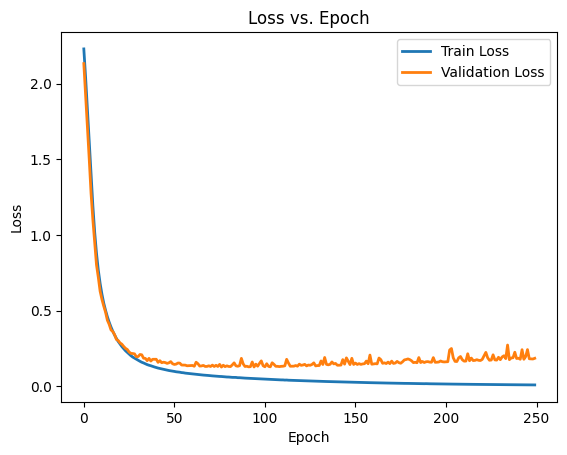

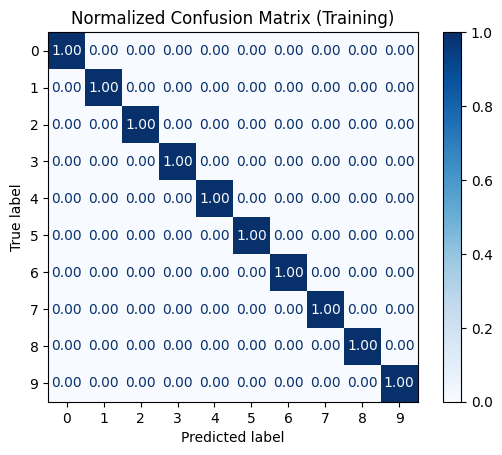

Normalized Accuracy (Training): 0.9996712689020382


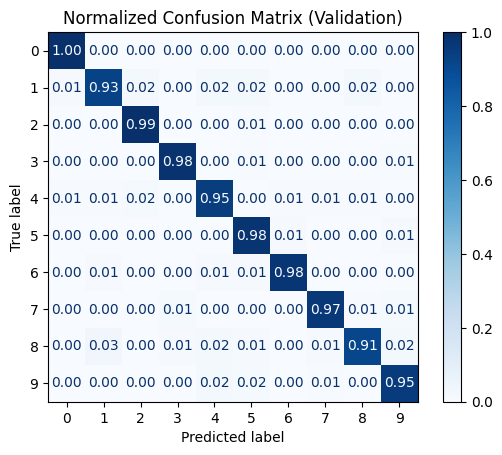

Normalized Accuracy (Validation): 0.9647509578544061


In [177]:
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train = []
loss_val = []
epochs = []

best_train_loss = 0.0  # Inicializar
patience = 0  # Número de épocas sin mejora antes de detener el entrenamiento
best_model = None #Guardamos la mejor instancia del modelo
# Entrenamiento de la red por n epocas
for epoch in range(250):

  # Guardar loss de cada batch
  loss_train_batches = []
  loss_val_batches = []

  # Entrenamiento --------------------------------------------------------------
  model.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)           # Predicciones
    loss = criterion(outputs, labels) # Loss de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model.eval()
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())


  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches

  # Guardamos la época
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))

  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?
  if epoch > 0:
    if ((loss_val[epoch] > loss_val[epoch-1]) and (loss_train[epoch] < loss_train[epoch-1])):
        patience +=1
        best_model = model.state_dict()
        # Comprobar si se debe detener el entrenamiento
    if patience == 250:
        best_model = model.state_dict()
        print("Early stopping. Validation loss hasn't improved for {} epochs.".format(patience))
        break  # Detener el bucle de entrenamiento

print(patience)
end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

import matplotlib.pyplot as plt

# Graficar el loss de entrenamiento y validación en función del tiempo
plt.figure()
plt.plot(epochs, loss_train, label="Train Loss", linewidth=2)
plt.plot(epochs, loss_val, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epoch")
plt.show()

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
model.load_state_dict(best_model)
# Obtener las predicciones en el conjunto de entrenamiento
model.eval()
train_predictions = []
train_labels = []

with torch.no_grad():
    for data_train in dataloader_train:
        inputs = data_train["features"].to(device)
        labels = data_train["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_predictions.extend(predicted.tolist())
        train_labels.extend(labels.tolist())

# Calcular la matriz de confusión
confusion = confusion_matrix( train_predictions, train_labels, normalize='true')

# Calcular el accuracy
accuracy = accuracy_score(train_predictions,train_labels)

# Mostrar la matriz de confusión con colores
disp = ConfusionMatrixDisplay(confusion, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Normalized Confusion Matrix (Training)")
plt.show()

print("Normalized Accuracy (Training):", accuracy)

# Obtener las predicciones en el conjunto de validación
model.eval()
val_predictions = []
val_labels = []

with torch.no_grad():
    for data_val in dataloader_val:
        inputs = data_val["features"].to(device)
        labels = data_val["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions.extend(predicted.tolist())
        val_labels.extend(labels.tolist())

# Calcular la matriz de confusión
val_confusion = confusion_matrix(val_predictions,val_labels, normalize='true')

# Calcular el accuracy
val_accuracy = accuracy_score(val_predictions,val_labels)

# Mostrar la matriz de confusión con colores
val_disp = ConfusionMatrixDisplay(val_confusion, display_labels=range(10))
val_disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Normalized Confusion Matrix (Validation)")
plt.show()

print("Normalized Accuracy (Validation):", val_accuracy)

## (a) Entrenar una red neuronal con 10 neuronas en la capa oculta y función de activación ReLU, y 1000 épocas como máximo:

Epoch: 0, train loss: 2.2848, val loss: 2.1838
Epoch: 1, train loss: 2.0958, val loss: 1.9706
Epoch: 2, train loss: 1.8943, val loss: 1.7801
Epoch: 3, train loss: 1.6791, val loss: 1.5192
Epoch: 4, train loss: 1.4707, val loss: 1.3315
Epoch: 5, train loss: 1.2763, val loss: 1.1699
Epoch: 6, train loss: 1.1021, val loss: 0.9801
Epoch: 7, train loss: 0.9527, val loss: 0.8513
Epoch: 8, train loss: 0.8266, val loss: 0.7565
Epoch: 9, train loss: 0.7225, val loss: 0.6567
Epoch: 10, train loss: 0.6370, val loss: 0.5715
Epoch: 11, train loss: 0.5656, val loss: 0.5129
Epoch: 12, train loss: 0.5087, val loss: 0.4709
Epoch: 13, train loss: 0.4615, val loss: 0.4226
Epoch: 14, train loss: 0.4215, val loss: 0.3928
Epoch: 15, train loss: 0.3890, val loss: 0.3606
Epoch: 16, train loss: 0.3617, val loss: 0.3283
Epoch: 17, train loss: 0.3363, val loss: 0.3254
Epoch: 18, train loss: 0.3164, val loss: 0.2875
Epoch: 19, train loss: 0.2980, val loss: 0.2706
Epoch: 20, train loss: 0.2819, val loss: 0.2652
Ep

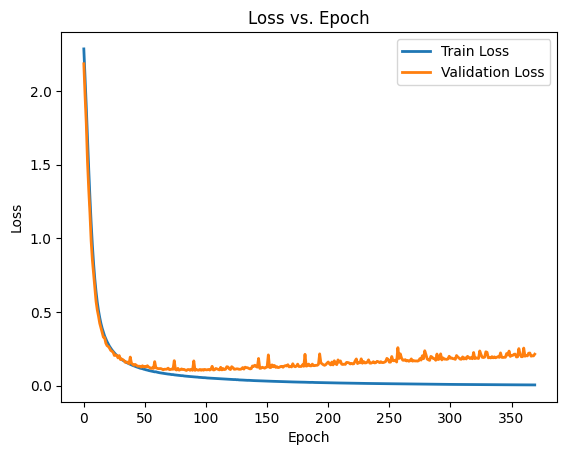

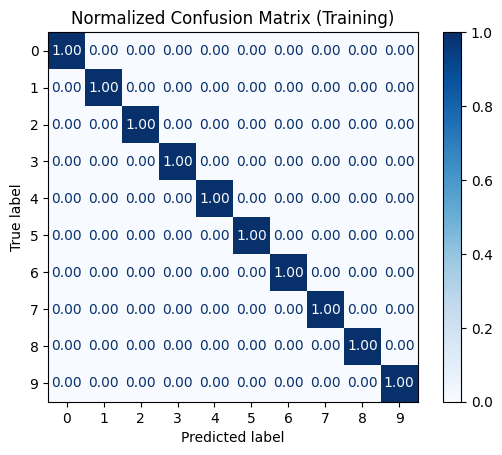

Normalized Accuracy (Training): 0.9996712689020382


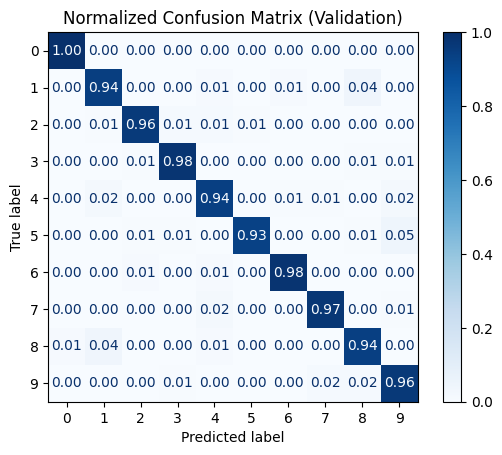

Normalized Accuracy (Validation): 0.960919540229885


In [179]:
# Crear modelo
model_a = nn.Sequential(
    nn.Linear(64, 10),
    nn.ReLU(),
    nn.Linear(10, 10)
)
model_a = model_a.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_a.parameters(), lr=1e-3)


start = time.time()
best_model_a= None
# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train_a = []
loss_val_a = []
epochs_a = []

best_train_loss = 0.0  # Inicializar
patience = 0  # Número de épocas sin mejora antes de detener el entrenamiento

# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches_a = []
  loss_val_batches_a = []

  # Entrenamiento --------------------------------------------------------------
  model_a.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model_a(inputs)           # Predicciones
    loss_a = criterion(outputs, labels) # Loss de entrenamiento
    loss_a.backward()                   # Backpropagation
    optimizer.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches_a.append(loss_a.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train_a.append(np.mean(loss_train_batches_a)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model_a.eval()
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model_a(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss_a = criterion(outputs, labels)
      loss_val_batches_a.append(loss_a.item())


  # Guardamos el Loss de validación de la época actual
  loss_val_a.append(np.mean(loss_val_batches_a)) # Loss promedio de los batches

  # Guardamos la época
  epochs_a.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train_a[epoch], loss_val_a[epoch])))

  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?
  if epoch > 0:
    if ((loss_val_a[epoch] > loss_val_a[epoch-1]) and (loss_train_a[epoch] < loss_train_a[epoch-1])):
        patience +=1
        # Comprobar si se debe detener el entrenamiento
    if patience == 150:
        best_model_a = model_a.state_dict()
        print("Early stopping. Validation loss hasn't improved for {} epochs.".format(patience))
        break  # Detener el bucle de entrenamiento

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

# Graficar el loss de entrenamiento y validación en función del tiempo
plt.figure()
plt.plot(epochs_a, loss_train_a, label="Train Loss", linewidth=2)
plt.plot(epochs_a, loss_val_a, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epoch")
plt.show()



# Obtener las predicciones en el conjunto de entrenamiento
model_a.load_state_dict(best_model_a)
model_a.eval()
train_predictions_a = []
train_labels_a = []

with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model_a(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_predictions_a.extend(predicted.cpu().numpy())
        train_labels_a.extend(labels.cpu().numpy())

# Calcular la matriz de confusión
confusion_a = confusion_matrix(train_labels_a, train_predictions_a, normalize='true')

# Calcular el accuracy
accuracy_a = accuracy_score(train_labels_a, train_predictions_a)

# Mostrar la matriz de confusión con colores
disp = ConfusionMatrixDisplay(confusion_a, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Normalized Confusion Matrix (Training)")
plt.show()

print("Normalized Accuracy (Training):", accuracy_a)

# Obtener las predicciones en el conjunto de validación
model_a.eval()
val_predictions_a = []
val_labels_a = []

with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model_a(inputs)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions_a.extend(predicted.cpu().numpy())
        val_labels_a.extend(labels.cpu().numpy())

# Calcular la matriz de confusión
val_confusion_a = confusion_matrix(val_labels_a, val_predictions_a, normalize='true')

# Calcular el accuracy
val_accuracy_a = accuracy_score(val_labels_a, val_predictions_a)

# Mostrar la matriz de confusión con colores
val_disp_a = ConfusionMatrixDisplay(val_confusion_a, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
val_disp_a.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Normalized Confusion Matrix (Validation)")
plt.show()

print("Normalized Accuracy (Validation):", val_accuracy_a)


## (b) Entrenar una red neuronal con 40 neuronas en la capa oculta y función de activación ReLU, y 1000 épocas como máximo:

Epoch: 0, train loss: 2.1122, val loss: 1.8911
Epoch: 1, train loss: 1.6931, val loss: 1.4517
Epoch: 2, train loss: 1.2659, val loss: 1.0513
Epoch: 3, train loss: 0.8990, val loss: 0.7456
Epoch: 4, train loss: 0.6430, val loss: 0.5516
Epoch: 5, train loss: 0.4788, val loss: 0.4160
Epoch: 6, train loss: 0.3746, val loss: 0.3484
Epoch: 7, train loss: 0.3049, val loss: 0.2828
Epoch: 8, train loss: 0.2580, val loss: 0.2538
Epoch: 9, train loss: 0.2236, val loss: 0.2227
Epoch: 10, train loss: 0.1976, val loss: 0.2179
Epoch: 11, train loss: 0.1768, val loss: 0.1942
Epoch: 12, train loss: 0.1614, val loss: 0.1753
Epoch: 13, train loss: 0.1475, val loss: 0.1820
Epoch: 14, train loss: 0.1358, val loss: 0.1517
Epoch: 15, train loss: 0.1263, val loss: 0.1461
Epoch: 16, train loss: 0.1179, val loss: 0.1424
Epoch: 17, train loss: 0.1096, val loss: 0.1310
Epoch: 18, train loss: 0.1038, val loss: 0.1316
Epoch: 19, train loss: 0.0974, val loss: 0.1282
Epoch: 20, train loss: 0.0914, val loss: 0.1211
Ep

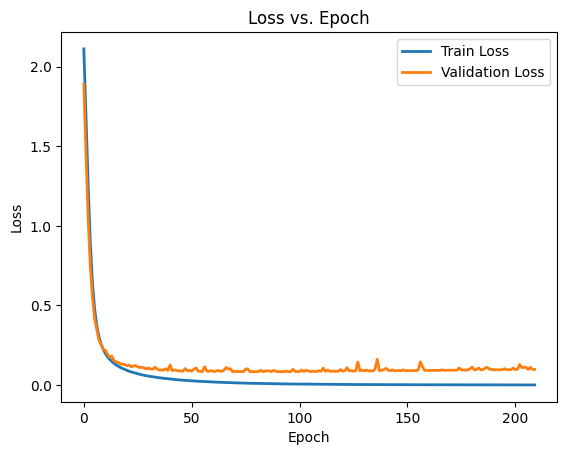

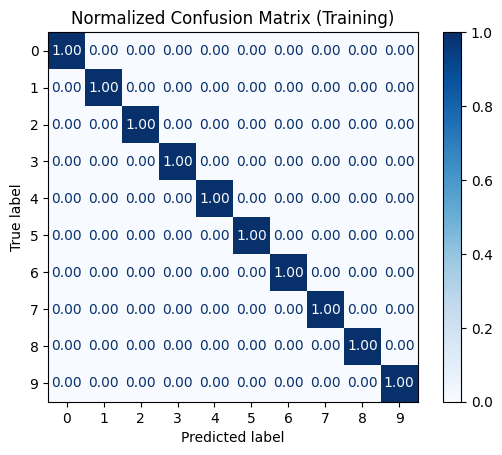

Normalized Accuracy (Training): 1.0


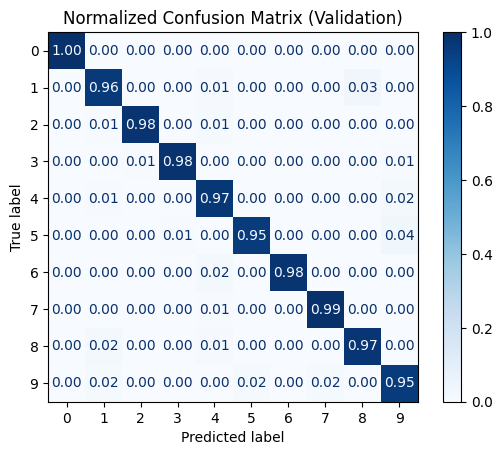

Normalized Accuracy (Validation): 0.9754789272030652


In [180]:
# Crear modelo
model_b = nn.Sequential(
    nn.Linear(64, 40),
    nn.ReLU(),
    nn.Linear(40, 10)
)
model_b = model_b.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_b.parameters(), lr=1e-3)

# Inicializar variables de tiempo
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train_b = []
loss_val_b = []
epochs_b = []

best_train_loss = 0.0  # Inicializar
patience = 0  # Número de épocas sin mejora antes de detener el entrenamiento
best_model_b = None
# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches_b = []
  loss_val_batches_b = []

  # Entrenamiento --------------------------------------------------------------
  model_b.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model_b(inputs)           # Predicciones
    loss_b = criterion(outputs, labels) # Loss de entrenamiento
    loss_b.backward()                   # Backpropagation
    optimizer.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches_b.append(loss_b.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train_b.append(np.mean(loss_train_batches_b)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model_b.eval()
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model_b(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss_b = criterion(outputs, labels)
      loss_val_batches_b.append(loss_b.item())


  # Guardamos el Loss de validación de la época actual
  loss_val_b.append(np.mean(loss_val_batches_b)) # Loss promedio de los batches

  # Guardamos la época
  epochs_b.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train_b[epoch], loss_val_b[epoch])))

  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?

  if epoch > 0:
    if ((loss_val_b[epoch] > loss_val_b[epoch-1]) and (loss_train_b[epoch] < loss_train_b[epoch-1])):
        patience +=1
        # Comprobar si se debe detener el entrenamiento
    if patience == 100:
        best_model_b = model_b.state_dict()
        print("Early stopping. Validation loss hasn't improved for {} epochs.".format(patience))
        break  # Detener el bucle de entrenamiento

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

# Graficar el loss de entrenamiento y validación en función del tiempo
plt.figure()
plt.plot(epochs_b, loss_train_b, label="Train Loss", linewidth=2)
plt.plot(epochs_b, loss_val_b, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epoch")
plt.show()



# Obtener las predicciones en el conjunto de entrenamiento
model_b.load_state_dict(best_model_b)
model_b.eval()
train_predictions_b = []
train_labels_b = []

with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model_b(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_predictions_b.extend(predicted.cpu().numpy())
        train_labels_b.extend(labels.cpu().numpy())

# Calcular la matriz de confusión
confusion_b = confusion_matrix(train_labels_b, train_predictions_b, normalize='true')

# Calcular el accuracy
accuracy_b = accuracy_score(train_labels_b, train_predictions_b)

# Mostrar la matriz de confusión con colores
disp = ConfusionMatrixDisplay(confusion_b, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Normalized Confusion Matrix (Training)")
plt.show()

print("Normalized Accuracy (Training):", accuracy_b)

# Obtener las predicciones en el conjunto de validación
model_b.eval()
val_predictions_b = []
val_labels_b = []

with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model_b(inputs)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions_b.extend(predicted.cpu().numpy())
        val_labels_b.extend(labels.cpu().numpy())

# Calcular la matriz de confusión
val_confusion_b = confusion_matrix(val_labels_b, val_predictions_b, normalize='true')

# Calcular el accuracy
val_accuracy_b = accuracy_score(val_labels_b, val_predictions_b)

# Mostrar la matriz de confusión con colores
val_disp_b = ConfusionMatrixDisplay(val_confusion_b, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
val_disp_b.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Normalized Confusion Matrix (Validation)")
plt.show()

print("Normalized Accuracy (Validation):", val_accuracy_b)

## (c) Entrenar una red neuronal con 10 neuronas en la capa oculta y función de activación Tanh, y 1000 épocas como máximo:

Epoch: 0, train loss: 2.2707, val loss: 2.1311
Epoch: 1, train loss: 2.0381, val loss: 1.9066
Epoch: 2, train loss: 1.8497, val loss: 1.7528
Epoch: 3, train loss: 1.6886, val loss: 1.5964
Epoch: 4, train loss: 1.5440, val loss: 1.4555
Epoch: 5, train loss: 1.4125, val loss: 1.3386
Epoch: 6, train loss: 1.2891, val loss: 1.2188
Epoch: 7, train loss: 1.1785, val loss: 1.1220
Epoch: 8, train loss: 1.0742, val loss: 1.0107
Epoch: 9, train loss: 0.9814, val loss: 0.9241
Epoch: 10, train loss: 0.8979, val loss: 0.8440
Epoch: 11, train loss: 0.8228, val loss: 0.7801
Epoch: 12, train loss: 0.7552, val loss: 0.7158
Epoch: 13, train loss: 0.6975, val loss: 0.6711
Epoch: 14, train loss: 0.6450, val loss: 0.6157
Epoch: 15, train loss: 0.5990, val loss: 0.5832
Epoch: 16, train loss: 0.5593, val loss: 0.5420
Epoch: 17, train loss: 0.5231, val loss: 0.5052
Epoch: 18, train loss: 0.4908, val loss: 0.4738
Epoch: 19, train loss: 0.4635, val loss: 0.4467
Epoch: 20, train loss: 0.4375, val loss: 0.4418
Ep

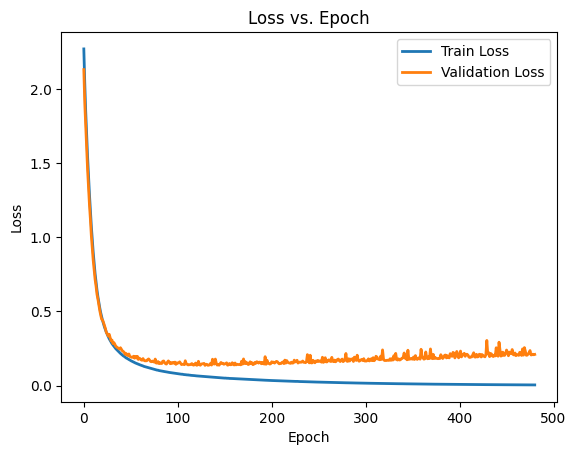

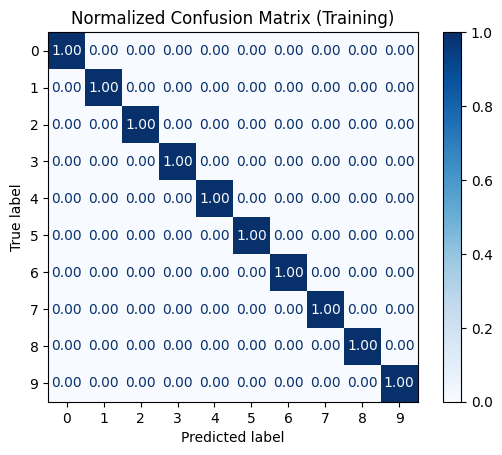

Normalized Accuracy (Training): 1.0


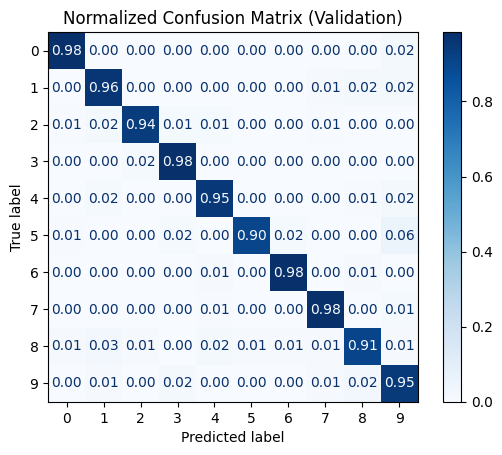

Normalized Accuracy (Validation): 0.9540229885057471


In [181]:
# Crear modelo
model_c = nn.Sequential(
    nn.Linear(64, 10),
    nn.Tanh(),
    nn.Linear(10, 10)
)
model_c = model_c.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_c.parameters(), lr=1e-3)

# Inicializar variables de tiempo
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train_c = []
loss_val_c = []
epochs_c = []

best_train_loss = 0.0  # Inicializar
patience = 0  # Número de épocas sin mejora antes de detener el entrenamiento
best_model_c= None
# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches_c = []
  loss_val_batches_c = []

  # Entrenamiento --------------------------------------------------------------
  model_c.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model_c(inputs)           # Predicciones
    loss_c = criterion(outputs, labels) # Loss de entrenamiento
    loss_c.backward()                   # Backpropagation
    optimizer.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches_c.append(loss_c.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train_c.append(np.mean(loss_train_batches_c)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model_c.eval()
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model_c(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss_c = criterion(outputs, labels)
      loss_val_batches_c.append(loss_c.item())


  # Guardamos el Loss de validación de la época actual
  loss_val_c.append(np.mean(loss_val_batches_c)) # Loss promedio de los batches

  # Guardamos la época
  epochs_c.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train_c[epoch], loss_val_c[epoch])))

  if epoch > 0:
    if (loss_val_c[epoch] > loss_val_c[epoch-1] and loss_train_c[epoch] < loss_train_c[epoch-1]):
        patience +=1
        # Comprobar si se debe detener el entrenamiento
    if patience == 200:
        best_model_c = model_c.state_dict()
        print("Early stopping. Validation loss hasn't improved for {} epochs.".format(patience))
        break  # Detener el bucle de entrenamiento

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

# Graficar el loss de entrenamiento y validación en función del tiempo
plt.figure()
plt.plot(epochs_c, loss_train_c, label="Train Loss", linewidth=2)
plt.plot(epochs_c, loss_val_c, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epoch")
plt.show()



# Obtener las predicciones en el conjunto de entrenamiento
model_c.load_state_dict(best_model_c)
model_c.eval()
train_predictions_c = []
train_labels_c = []

with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model_c(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_predictions_c.extend(predicted.tolist())
        train_labels_c.extend(labels.tolist())

# Calcular la matriz de confusión
confusion_c = confusion_matrix(train_labels_c, train_predictions_c, normalize='true')

# Calcular el accuracy
accuracy_c = accuracy_score(train_labels_c, train_predictions_c)

# Mostrar la matriz de confusión con colores
disp = ConfusionMatrixDisplay(confusion_c, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Normalized Confusion Matrix (Training)")
plt.show()

print("Normalized Accuracy (Training):", accuracy_c)

# Obtener las predicciones en el conjunto de validación
model_c.eval()
val_predictions_c = []
val_labels_c = []

with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model_c(inputs)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions_c.extend(predicted.tolist())
        val_labels_c.extend(labels.tolist())

# Calcular la matriz de confusión
val_confusion_c = confusion_matrix(val_labels_c, val_predictions_c, normalize='true')

# Calcular el accuracy
val_accuracy_c = accuracy_score(val_labels_c, val_predictions_c)

# Mostrar la matriz de confusión con colores
val_disp_c = ConfusionMatrixDisplay(val_confusion_c, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
val_disp_c.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Normalized Confusion Matrix (Validation)")
plt.show()

print("Normalized Accuracy (Validation):", val_accuracy_c)



## (d) Entrenar una red neuronal con 40 neuronas en la capa oculta y función de activación Tanh, y 1000 épocas como máximo:

Epoch: 0, train loss: 2.0027, val loss: 1.7098
Epoch: 1, train loss: 1.4809, val loss: 1.2603
Epoch: 2, train loss: 1.0893, val loss: 0.9264
Epoch: 3, train loss: 0.8081, val loss: 0.6978
Epoch: 4, train loss: 0.6183, val loss: 0.5552
Epoch: 5, train loss: 0.4888, val loss: 0.4523
Epoch: 6, train loss: 0.4000, val loss: 0.3751
Epoch: 7, train loss: 0.3382, val loss: 0.3251
Epoch: 8, train loss: 0.2926, val loss: 0.2853
Epoch: 9, train loss: 0.2583, val loss: 0.2588
Epoch: 10, train loss: 0.2321, val loss: 0.2286
Epoch: 11, train loss: 0.2099, val loss: 0.2207
Epoch: 12, train loss: 0.1935, val loss: 0.2055
Epoch: 13, train loss: 0.1773, val loss: 0.1869
Epoch: 14, train loss: 0.1652, val loss: 0.1753
Epoch: 15, train loss: 0.1543, val loss: 0.1753
Epoch: 16, train loss: 0.1453, val loss: 0.1640
Epoch: 17, train loss: 0.1366, val loss: 0.1507
Epoch: 18, train loss: 0.1289, val loss: 0.1567
Epoch: 19, train loss: 0.1227, val loss: 0.1433
Epoch: 20, train loss: 0.1161, val loss: 0.1321
Ep

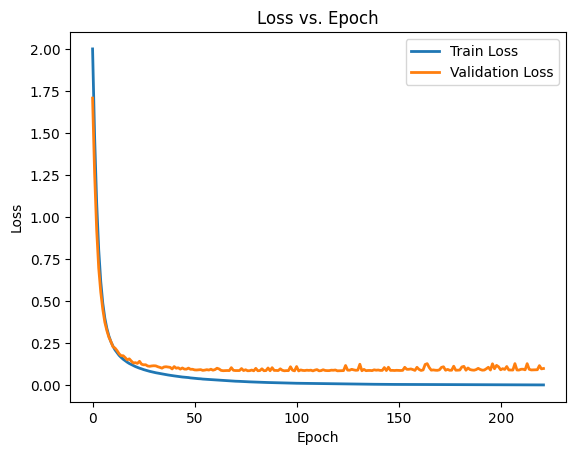

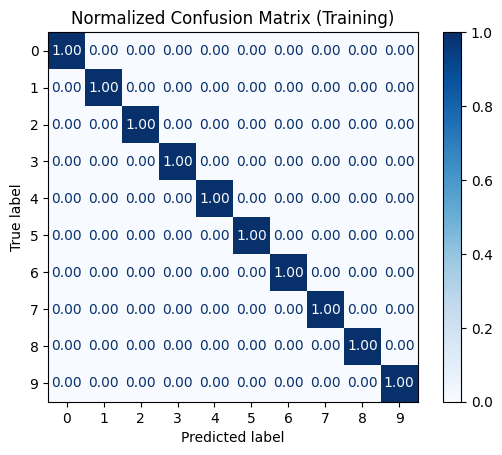

Normalized Accuracy (Training): 1.0


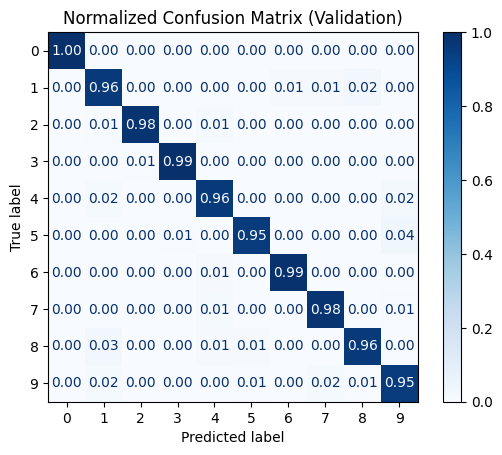

Normalized Accuracy (Validation): 0.9731800766283525


In [182]:
# Crear modelo
model_d = nn.Sequential(
    nn.Linear(64, 40),
    nn.Tanh(),
    nn.Linear(40, 10)
)
model_d = model_d.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_d.parameters(), lr=1e-3)

# Inicializar variables de tiempo
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train_d = []
loss_val_d = []
epochs_d = []

best_train_loss = 0.0  # Inicializar
patience = 0  # Número de épocas sin mejora antes de detener el entrenamiento
best_model_d = None
# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches_d = []
  loss_val_batches_d = []

  # Entrenamiento --------------------------------------------------------------
  model_d.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model_d(inputs)           # Predicciones
    loss_d = criterion(outputs, labels) # Loss de entrenamiento
    loss_d.backward()                   # Backpropagation
    optimizer.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches_d.append(loss_d.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train_d.append(np.mean(loss_train_batches_d)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model_d.eval()
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model_d(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss_d = criterion(outputs, labels)
      loss_val_batches_d.append(loss_d.item())


  # Guardamos el Loss de validación de la época actual
  loss_val_d.append(np.mean(loss_val_batches_d)) # Loss promedio de los batches

  # Guardamos la época
  epochs_d.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train_d[epoch], loss_val_d[epoch])))

  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?
  if epoch > 0:
    if (loss_val_d[epoch] > loss_val_d[epoch-1] and loss_train_d[epoch] < loss_train_d[epoch-1]):
        patience +=1
        # Comprobar si se debe detener el entrenamiento
    if patience == 100:
        best_model_d = model_d.state_dict()
        print("Early stopping. Validation loss hasn't improved for {} epochs.".format(patience))
        break  # Detener el bucle de entrenamiento

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

# Graficar el loss de entrenamiento y validación en función del tiempo
plt.figure()
plt.plot(epochs_d, loss_train_d, label="Train Loss", linewidth=2)
plt.plot(epochs_d, loss_val_d, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epoch")
plt.show()



# Obtener las predicciones en el conjunto de entrenamiento
model_d.load_state_dict(best_model_d)
model_d.eval()
train_predictions_d = []
train_labels_d = []

with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model_d(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_predictions_d.extend(predicted.cpu().numpy())
        train_labels_d.extend(labels.cpu().numpy())

# Calcular la matriz de confusión
confusion_d = confusion_matrix(train_labels_d, train_predictions_d, normalize='true')

# Calcular el accuracy
accuracy_d = accuracy_score(train_labels_d, train_predictions_d)

# Mostrar la matriz de confusión con colores
disp = ConfusionMatrixDisplay(confusion_d, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Normalized Confusion Matrix (Training)")
plt.show()

print("Normalized Accuracy (Training):", accuracy_d)

# Obtener las predicciones en el conjunto de validación
model_d.eval()
val_predictions_d = []
val_labels_d = []

with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model_d(inputs)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions_d.extend(predicted.cpu().numpy())
        val_labels_d.extend(labels.cpu().numpy())

# Calcular la matriz de confusión
val_confusion_d = confusion_matrix(val_labels_d, val_predictions_d, normalize='true')

# Calcular el accuracy
val_accuracy_d = accuracy_score(val_labels_d, val_predictions_d)

# Mostrar la matriz de confusión con colores
val_disp_d = ConfusionMatrixDisplay(val_confusion_d, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
val_disp_d.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Normalized Confusion Matrix (Validation)")
plt.show()

print("Normalized Accuracy (Validation):", val_accuracy_d)


## (e) Entrenar una red neuronal con 2 capas ocultas, 10 neuronas cada una y función de activación ReLU, y 1000 épocas como máximo:

Epoch: 0, train loss: 2.3208, val loss: 2.2683
Epoch: 1, train loss: 2.2255, val loss: 2.1584
Epoch: 2, train loss: 2.0781, val loss: 1.9595
Epoch: 3, train loss: 1.8448, val loss: 1.6824
Epoch: 4, train loss: 1.5662, val loss: 1.4142
Epoch: 5, train loss: 1.3123, val loss: 1.1971
Epoch: 6, train loss: 1.1049, val loss: 0.9980
Epoch: 7, train loss: 0.9468, val loss: 0.8791
Epoch: 8, train loss: 0.8311, val loss: 0.7785
Epoch: 9, train loss: 0.7390, val loss: 0.6900
Epoch: 10, train loss: 0.6636, val loss: 0.6308
Epoch: 11, train loss: 0.5956, val loss: 0.5567
Epoch: 12, train loss: 0.5322, val loss: 0.4918
Epoch: 13, train loss: 0.4719, val loss: 0.4595
Epoch: 14, train loss: 0.4183, val loss: 0.3863
Epoch: 15, train loss: 0.3708, val loss: 0.3496
Epoch: 16, train loss: 0.3330, val loss: 0.3147
Epoch: 17, train loss: 0.3005, val loss: 0.2897
Epoch: 18, train loss: 0.2750, val loss: 0.2585
Epoch: 19, train loss: 0.2565, val loss: 0.2642
Epoch: 20, train loss: 0.2389, val loss: 0.2644
Ep

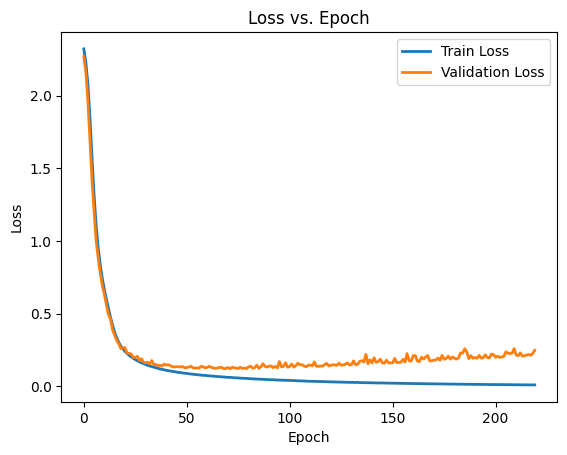

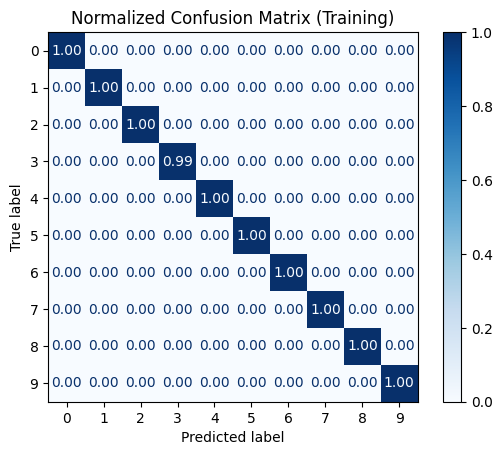

Normalized Accuracy (Training): 0.9986850756081526


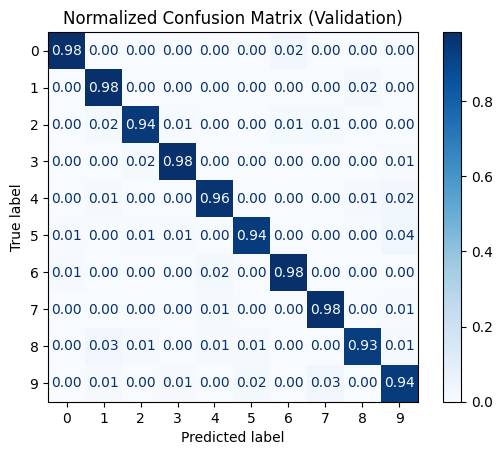

Normalized Accuracy (Validation): 0.960919540229885


In [183]:
# Crear modelo
model_e = nn.Sequential(
    nn.Linear(64, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 10)
)
model_e = model_e.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_e.parameters(), lr=1e-3)

# Inicializar variables de tiempo
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train_e = []
loss_val_e = []
epochs_e = []

best_train_loss = 0.0  # Inicializar
patience = 0  # Número de épocas sin mejora antes de detener el entrenamiento
best_model_e = None
# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches_e = []
  loss_val_batches_e = []

  # Entrenamiento --------------------------------------------------------------
  model_e.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model_e(inputs)           # Predicciones
    loss_e = criterion(outputs, labels) # Loss de entrenamiento
    loss_e.backward()                   # Backpropagation
    optimizer.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches_e.append(loss_e.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train_e.append(np.mean(loss_train_batches_e)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model_e.eval()
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model_e(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss_e = criterion(outputs, labels)
      loss_val_batches_e.append(loss_e.item())


  # Guardamos el Loss de validación de la época actual
  loss_val_e.append(np.mean(loss_val_batches_e)) # Loss promedio de los batches

  # Guardamos la época
  epochs_e.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train_e[epoch], loss_val_e[epoch])))

  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?
  if epoch > 0:
    if (loss_val_e[epoch] > loss_val_e[epoch-1] and loss_train_e[epoch] < loss_train_e[epoch-1]):
        patience +=1
        # Comprobar si se debe detener el entrenamiento
    if patience == 100:
        best_model_e = model_e.state_dict()
        print("Early stopping. Validation loss hasn't improved for {} epochs.".format(patience))
        break  # Detener el bucle de entrenamiento

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

# Graficar el loss de entrenamiento y validación en función del tiempo
plt.figure()
plt.plot(epochs_e, loss_train_e, label="Train Loss", linewidth=2)
plt.plot(epochs_e, loss_val_e, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epoch")
plt.show()



# Obtener las predicciones en el conjunto de entrenamiento
model_e.load_state_dict(best_model_e)
model_e.eval()
train_predictions_e = []
train_labels_e = []

with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model_e(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_predictions_e.extend(predicted.cpu().numpy())
        train_labels_e.extend(labels.cpu().numpy())

# Calcular la matriz de confusión
confusion_e = confusion_matrix(train_labels_e, train_predictions_e, normalize='true')

# Calcular el accuracy
accuracy_e = accuracy_score(train_labels_e, train_predictions_e)

# Mostrar la matriz de confusión con colores
disp = ConfusionMatrixDisplay(confusion_e, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Normalized Confusion Matrix (Training)")
plt.show()

print("Normalized Accuracy (Training):", accuracy_e)

# Obtener las predicciones en el conjunto de validación
model_e.eval()
val_predictions_e = []
val_labels_e = []

with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model_e(inputs)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions_e.extend(predicted.cpu().numpy())
        val_labels_e.extend(labels.cpu().numpy())

# Calcular la matriz de confusión
val_confusion_e = confusion_matrix(val_labels_e, val_predictions_e, normalize='true')

# Calcular el accuracy
val_accuracy_e = accuracy_score(val_labels_e, val_predictions_e)

# Mostrar la matriz de confusión con colores
val_disp_e = ConfusionMatrixDisplay(val_confusion_e, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
val_disp_e.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Normalized Confusion Matrix (Validation)")
plt.show()

print("Normalized Accuracy (Validation):", val_accuracy_e)

## (f) Entrenar una red neuronal con 2 capas ocultas, 40 neuronas cada una y función de activación ReLU, y 1000 épocas como máximo:

Epoch: 0, train loss: 2.1898, val loss: 2.0256
Epoch: 1, train loss: 1.7861, val loss: 1.4767
Epoch: 2, train loss: 1.1525, val loss: 0.8332
Epoch: 3, train loss: 0.6104, val loss: 0.4290
Epoch: 4, train loss: 0.3483, val loss: 0.2865
Epoch: 5, train loss: 0.2452, val loss: 0.2162
Epoch: 6, train loss: 0.1931, val loss: 0.1749
Epoch: 7, train loss: 0.1628, val loss: 0.1522
Epoch: 8, train loss: 0.1401, val loss: 0.1356
Epoch: 9, train loss: 0.1231, val loss: 0.1240
Epoch: 10, train loss: 0.1086, val loss: 0.1319
Epoch: 11, train loss: 0.0986, val loss: 0.1178
Epoch: 12, train loss: 0.0877, val loss: 0.1033
Epoch: 13, train loss: 0.0804, val loss: 0.1043
Epoch: 14, train loss: 0.0723, val loss: 0.0932
Epoch: 15, train loss: 0.0661, val loss: 0.0968
Epoch: 16, train loss: 0.0598, val loss: 0.0986
Epoch: 17, train loss: 0.0558, val loss: 0.0898
Epoch: 18, train loss: 0.0508, val loss: 0.0867
Epoch: 19, train loss: 0.0467, val loss: 0.0854
Epoch: 20, train loss: 0.0431, val loss: 0.0795
Ep

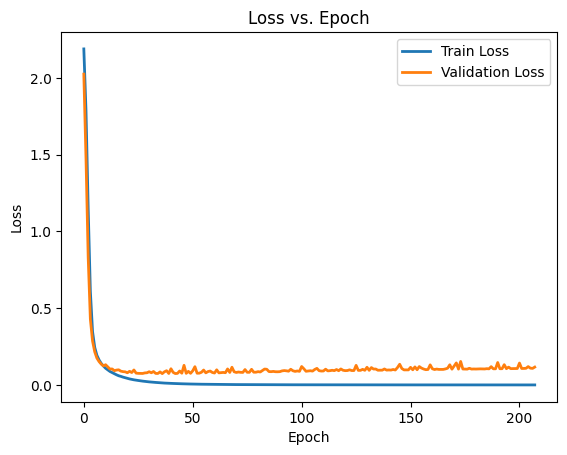

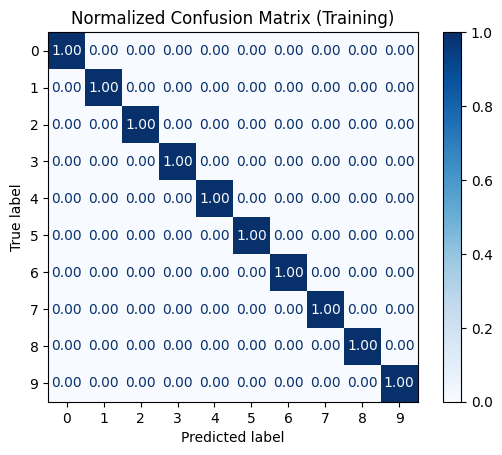

Normalized Accuracy (Training): 1.0


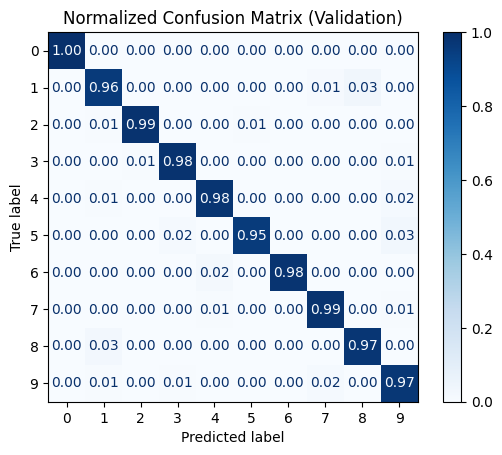

Normalized Accuracy (Validation): 0.9777777777777777


In [184]:
# Crear modelo
model_f = nn.Sequential(
    nn.Linear(64, 40),
    nn.ReLU(),
    nn.Linear(40, 40),
    nn.ReLU(),
    nn.Linear(40, 10)
)
model_f = model_f.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_f.parameters(), lr=1e-3)

# Inicializar variables de tiempo
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train_f = []
loss_val_f = []
epochs_f = []

best_train_loss = 0.0  # Inicializar
patience = 0  # Número de épocas sin mejora antes de detener el entrenamiento
best_model_f = None
# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches_f = []
  loss_val_batches_f = []

  # Entrenamiento --------------------------------------------------------------
  model_f.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model_f(inputs)           # Predicciones
    loss_f = criterion(outputs, labels) # Loss de entrenamiento
    loss_f.backward()                   # Backpropagation
    optimizer.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches_f.append(loss_f.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train_f.append(np.mean(loss_train_batches_f)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model_f.eval()
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model_f(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss_f = criterion(outputs, labels)
      loss_val_batches_f.append(loss_f.item())


  # Guardamos el Loss de validación de la época actual
  loss_val_f.append(np.mean(loss_val_batches_f)) # Loss promedio de los batches

  # Guardamos la época
  epochs_f.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train_f[epoch], loss_val_f[epoch])))

  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?
  if epoch > 0:
    if (loss_val_f[epoch] > loss_val_f[epoch-1] and loss_train_f[epoch] < loss_train_f[epoch-1]):
        patience +=1
        # Comprobar si se debe detener el entrenamiento
    if patience == 100:
        best_model_f = model_f.state_dict()
        print("Early stopping. Validation loss hasn't improved for {} epochs.".format(patience))
        break  # Detener el bucle de entrenamiento

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

# Graficar el loss de entrenamiento y validación en función del tiempo
plt.figure()
plt.plot(epochs_f, loss_train_f, label="Train Loss", linewidth=2)
plt.plot(epochs_f, loss_val_f, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epoch")
plt.show()



# Obtener las predicciones en el conjunto de entrenamiento
model_f.load_state_dict(best_model_f)
model_f.eval()
train_predictions_f = []
train_labels_f = []

with torch.no_grad():
    for data in dataloader_train:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model_f(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_predictions_f.extend(predicted.cpu().numpy())
        train_labels_f.extend(labels.cpu().numpy())

# Calcular la matriz de confusión
confusion_f = confusion_matrix(train_labels_f, train_predictions_f, normalize='true')

# Calcular el accuracy
accuracy_f = accuracy_score(train_labels_f, train_predictions_f)

# Mostrar la matriz de confusión con colores
disp = ConfusionMatrixDisplay(confusion_f, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Normalized Confusion Matrix (Training)")
plt.show()

print("Normalized Accuracy (Training):", accuracy_f)

# Obtener las predicciones en el conjunto de validación
model_f.eval()
val_predictions_f = []
val_labels_f = []

with torch.no_grad():
    for data in dataloader_val:
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model_f(inputs)
        _, predicted = torch.max(outputs.data, 1)
        val_predictions_f.extend(predicted.cpu().numpy())
        val_labels_f.extend(labels.cpu().numpy())

# Calcular la matriz de confusión
val_confusion_f = confusion_matrix(val_labels_f, val_predictions_f, normalize='true')

# Calcular el accuracy
val_accuracy_f = accuracy_score(val_labels_f, val_predictions_f)

# Mostrar la matriz de confusión con colores
val_disp_f = ConfusionMatrixDisplay(val_confusion_f, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
val_disp_f.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Normalized Confusion Matrix (Validation)")
plt.show()

print("Normalized Accuracy (Validation):", val_accuracy_f)


## Comparacion y seleccion del mejor modelo segun Accuracy en Validacion

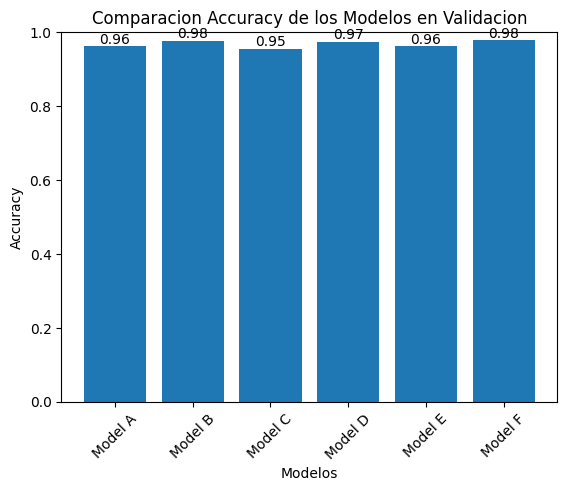

In [185]:
accuracies = [val_accuracy_a, val_accuracy_b, val_accuracy_c, val_accuracy_d, val_accuracy_e, val_accuracy_f]
model_names = ["Model A", "Model B", "Model C", "Model D", "Model E", "Model F"]

plt.bar(model_names, accuracies)
plt.xlabel('Modelos')
plt.ylabel('Accuracy')
plt.title('Comparacion Accuracy de los Modelos en Validacion')
plt.ylim(0, 1)
plt.xticks(rotation=45)

for i, acc in enumerate(accuracies):
    plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom')

plt.show()


## Calculando las metricas para el mejor modelo con los datos de PRUEBA


In [186]:
# Cargar y normalizar los datos del conjunto de prueba
feats_test = df_test.to_numpy()[:, 0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:, 64].astype(int)
feats_test = scaler.transform(feats_test)
dataset_test = [{"features": feats_test[i, :], "labels": labels_test[i]} for i in range(feats_test.shape[0])]
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=False, num_workers=0)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


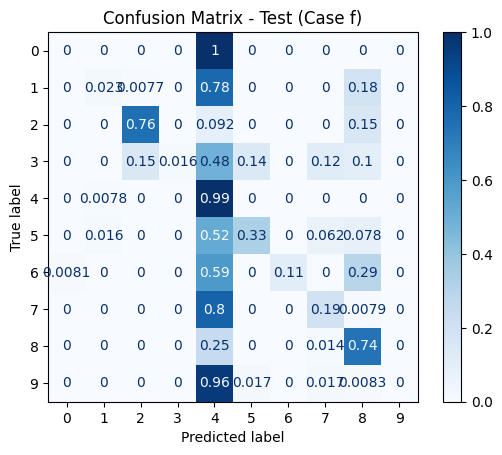

Accuracy - Test (Case f): 0.31761006289308175


In [187]:
# Cargar el estado de la mejor red en el modelo
model_f.load_state_dict(best_model_f)

# Evaluar la mejor red en el conjunto de prueba
model_f.eval()
pred_test_f = []
true_test_f = []

with torch.no_grad():
    for data_test in dataloader_test:
        inputs_test = data_test["features"].to(device)
        labels_test = data_test["labels"].to(device)
        outputs_test = model_f(inputs_test)
        _, predicted_test = torch.max(outputs_test.data, 1)

        pred_test_f.extend(predicted_test.tolist())
        true_test_f.extend(labels_test.tolist())

confusion_matrix_test_f = confusion_matrix(true_test_f, pred_test_f, normalize='true')
accuracy_test_f = accuracy_score(true_test_f, pred_test_f)

disp_test_f = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_test_f, display_labels=range(10))
disp_test_f.plot(cmap='Blues')
plt.title('Confusion Matrix - Test (Case f)')
plt.show()

print(f"Accuracy - Test (Case f): {accuracy_test_f}")



## Analisis de resultados y comparacion de métricas


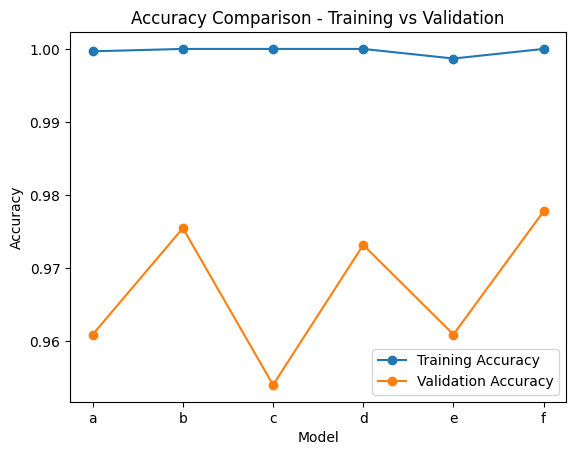

In [188]:
# Gráfico de línea de los accuracies de entrenamiento y validación
models = ['a', 'b', 'c', 'd', 'e', 'f']
accuracy_train = [accuracy_a, accuracy_b, accuracy_c, accuracy_d, accuracy_e, accuracy_f]
accuracy_val = [val_accuracy_a, val_accuracy_b, val_accuracy_c, val_accuracy_d, val_accuracy_e, val_accuracy_f]

plt.plot(models, accuracy_train, label='Training Accuracy', marker='o')
plt.plot(models, accuracy_val, label='Validation Accuracy', marker='o')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison - Training vs Validation')
plt.legend()
plt.show()

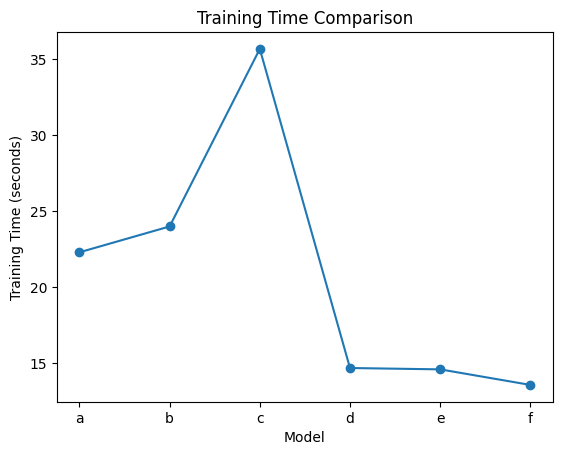

In [189]:
# Gráfico de línea de los tiempos de entrenamiento
training_times = [22.292522, 23.993313, 35.677886, 14.676463, 14.587411, 13.563620]

plt.plot(models, training_times, marker='o')
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.show()

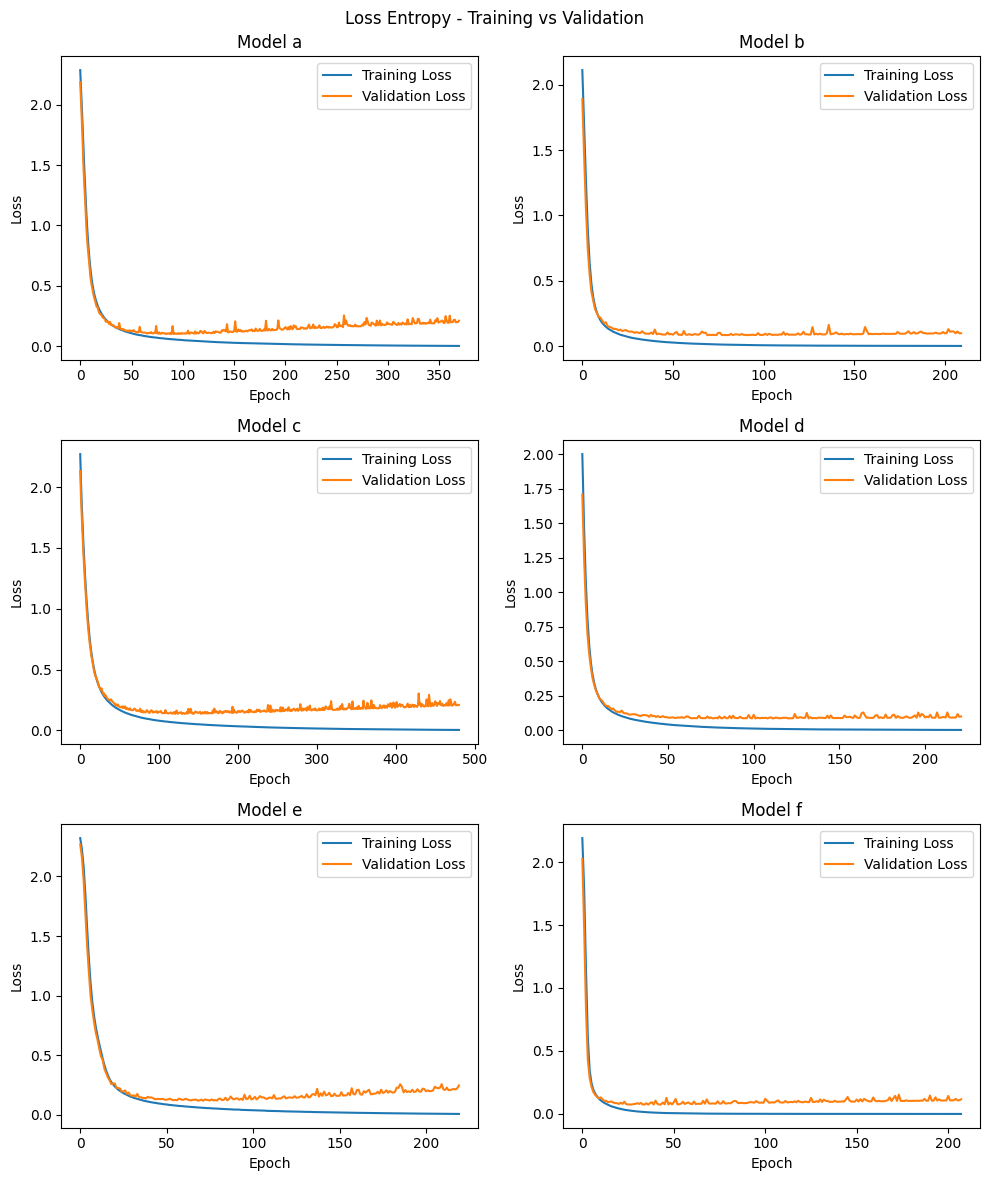

In [190]:
# Figura con subplots de las curvas de loss de entrenamiento y validación
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
fig.suptitle('Loss Entropy - Training vs Validation')

train_losses = [loss_train_a, loss_train_b, loss_train_c, loss_train_d, loss_train_e, loss_train_f]
val_losses = [loss_val_a, loss_val_b, loss_val_c, loss_val_d, loss_val_e, loss_val_f]

for i in range(3):
    for j in range(2):
        model_index = i * 2 + j
        axes[i, j].plot(train_losses[model_index], label='Training Loss')
        axes[i, j].plot(val_losses[model_index], label='Validation Loss')
        axes[i, j].set_title(f'Model {models[model_index]}')
        axes[i, j].set_xlabel('Epoch')
        axes[i, j].set_ylabel('Loss')
        axes[i, j].legend()

plt.tight_layout()
plt.show()

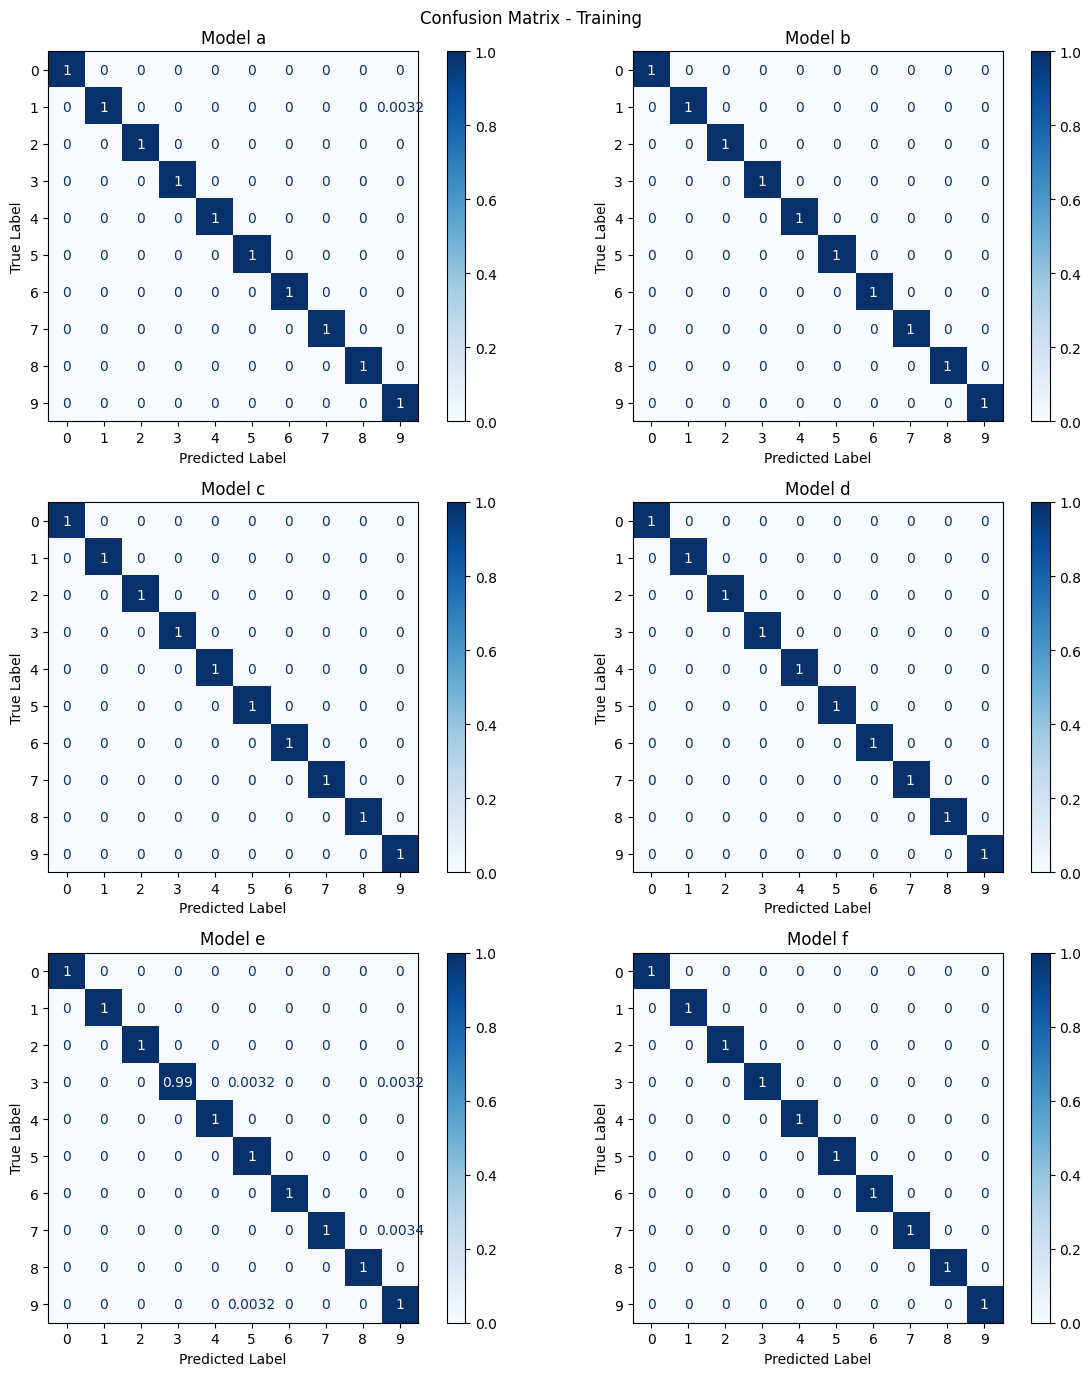

In [191]:
# Figura con subplots de las matrices de confusión normalizadas de entrenamiento
fig, axes = plt.subplots(3, 2, figsize=(12, 14))
fig.suptitle('Confusion Matrix - Training')

confusion_matrices_train = [confusion_a, confusion_b, confusion_c, confusion_d, confusion_e, confusion_f]

for i in range(3):
    for j in range(2):
        model_index = i * 2 + j
        disp_train = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices_train[model_index], display_labels=range(10))
        disp_train.plot(ax=axes[i, j], cmap='Blues')
        axes[i, j].set_title(f'Model {models[model_index]}')
        axes[i, j].set_xlabel('Predicted Label')
        axes[i, j].set_ylabel('True Label')

plt.tight_layout()
plt.show()

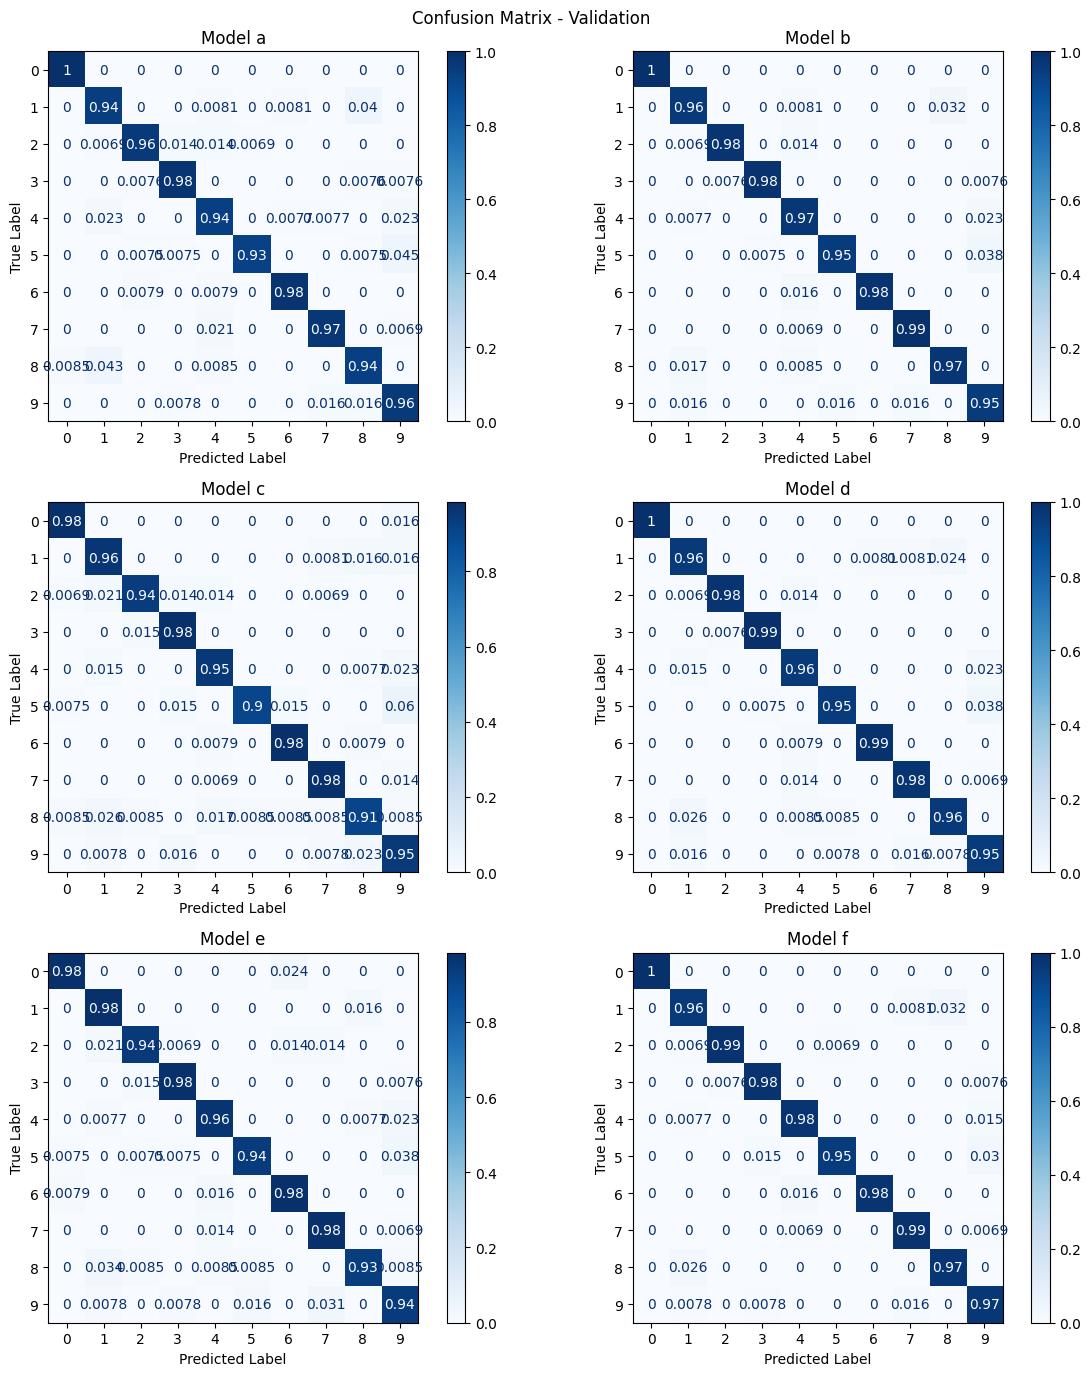

In [192]:
# Figura con subplots de las matrices de confusión normalizadas de validación
fig, axes = plt.subplots(3, 2, figsize=(12, 14))
fig.suptitle('Confusion Matrix - Validation')

confusion_matrices_val = [val_confusion_a, val_confusion_b, val_confusion_c, val_confusion_d, val_confusion_e, val_confusion_f]

for i in range(3):
    for j in range(2):
        model_index = i * 2 + j
        disp_val = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices_val[model_index], display_labels=range(10))
        disp_val.plot(ax=axes[i, j], cmap='Blues')
        axes[i, j].set_title(f'Model {models[model_index]}')
        axes[i, j].set_xlabel('Predicted Label')
        axes[i, j].set_ylabel('True Label')

plt.tight_layout()
plt.show()
